Jeyshinee Pyneeandee <br>
December 2023 <br>
This notebook tests the performance of KERAS-OCR after applying a cropping & de-noising filter on the ionograms. 

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras_ocr
import string 
import tempfile
from PIL import Image
import os
import random

#### Cropping and Denoising filters

In [3]:
#Uncomment variables based on model needed

#model 1
# imageHeight = 50
# top_noise_height = 18
# bottom_noise_height = 15
# threshold_toLine=(80, 80, 80, 255)
# threshold_towhite=(80, 80, 80, 255)
# threshold_toblack=(80, 80, 80, 255)
# start_row_to_process = 20
# end_row_to_process = 21

# #model 2 
# imageHeight = 50
# top_noise_height = 18
# bottom_noise_height = 15
# threshold_toLine=(80, 80, 80, 255)
# threshold_towhite=(32, 32, 32, 255)
# threshold_toblack=(0, 0, 0, 255)
# start_row_to_process = 20
# end_row_to_process = 21

#model 3 
imageHeight = 50
top_noise_height = 18
bottom_noise_height = 10
threshold_toLine=(110, 110, 110, 255)
threshold_towhite=(0, 0, 0, 255)
threshold_toblack=(80, 80, 80, 255)
start_row_to_process = 19
end_row_to_process = 20

In [4]:

#Staring by defining a crop and copy function: 
def crop_and_copy(input_path, output_path, imageHeight):
    # Open the input image
    with Image.open(input_path) as img:
        # Get the dimensions of the image
        width, height = img.size
        # Define the region to crop (imageHeight pixels from the bottom)
        crop_region = (0, height - imageHeight, width, height)
        # Crop the image
        cropped_img = img.crop(crop_region)
        # Create a new image with the same size as the cropped region
        new_img = Image.new("RGBA", (width, imageHeight), (0, 0, 0, 0))
        # Paste the cropped region onto the new image
        new_img.paste(cropped_img, (0, 0))
        # Save the result to the output path
        new_img.save(output_path.name)

# Continue then with a function to remove top noise and overwrite the image
def remove_top_bottom_noise(input_path, top_noise_height, bottom_noise_height):
    # Open the image
    with Image.open(input_path) as img:
        # Get the dimensions of the image
        width, height = img.size
        # Create a new image with the same content as the original
        new_img = img.copy()

        # Add a black border to the top noise height
        for y in range(top_noise_height):
            for x in range(width):
                new_img.putpixel((x, y), (0, 0, 0, 255))  # Set pixel to black
        # Remove noise from the bottom
        for y in range(height - bottom_noise_height, height):
            for x in range(width):
                new_img.putpixel((x, y), (0, 0, 0, 255))  # Set pixel to black

        # Save the result, overwriting the original image
        new_img.save(input_path.name)

def process_middle_lines_noise(input_path, threshold_toline, start_row, end_row):
    # Open the image
    img = Image.open(input_path)
    
    # Get the pixels
    pixels = img.load()
    width, height = img.size
    # Iterate through rows to process and replace colors below the threshold
    for y in range(start_row, end_row + 1):
        for x in range(width):
            r, g, b, a = pixels[x, y]
            if (r, g, b, a) < threshold_toline:
                pixels[x, y] = (0, 0, 0, 255)
    # Iterate through all rows to process the below threshold rest pixels to black
    for y in range(top_noise_height, imageHeight-bottom_noise_height):
        if y == 19 or y == 20:
           continue
        for x in range(width):
            r, g, b, a = pixels[x, y]
            if (r, g, b, a) < threshold_toblack:
                pixels[x, y] = (0, 0, 0, 255)
    # Iterate through all rows to process the rest pixels to white
    for y in range(top_noise_height, imageHeight-bottom_noise_height):
        for x in range(width):
            r, g, b, a = pixels[x, y]
            if (r, g, b, a) > threshold_towhite:
                pixels[x, y] = (255, 255, 255, 255)
    # Save the modified image
    img.save(input_path.name)
    return img


### KERAS-OCR Function
Right now, we are using a pre-trained detector and adding in a trained recognizer. 

In [5]:
# Added a recognizer to better read characters picked up 
recognizer = keras_ocr.recognition.Recognizer(alphabet= string.digits) 
recognizer.model.load_weights('L:/DATA/ISIS/keras_ocr_training/ISIS_reading.h5')   
recognizer.compile()  
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\jpyneeandee\.keras-ocr\crnn_kurapan_notop.h5
Looking for C:\Users\jpyneeandee\.keras-ocr\craft_mlt_25k.h5


In [31]:
def read_image(image_path, just_digits=False):
    try: 
        #applying cropping and de-noising filters
        output_file_path = tempfile.NamedTemporaryFile(delete = False, suffix=".png")
        crop_and_copy(image_path, output_file_path, imageHeight)
        remove_top_bottom_noise(output_file_path,top_noise_height,bottom_noise_height)
        image = process_middle_lines_noise(output_file_path,threshold_toLine,start_row_to_process,end_row_to_process)

        #saving image to temporary path
        temp_file_path = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
        plt.axis("off")        
        plt.imshow(image)
        plt.savefig(temp_file_path.name)
        plt.close()

        #reading both filtered & orignal image 
        image = keras_ocr.tools.read(output_file_path.name) 
        image_original = keras_ocr.tools.read(image_path) 

        list_images = []
        digitcount_total = []
        list_images.append(image)
        list_images.append(image_original)
        
        plt.axis("off")        
        plt.imshow(image_original)
        plt.show()
        plt.close()

        plt.axis("off")        
        plt.imshow(image)
        plt.show()
        plt.close()

        #applying KERAS on each image to compare performance
        for im in list_images:
            prediction = pipeline.recognize([im])[0]
            # if no characters are found move on
            if prediction == [[]]:
                digit_count = 0

            # if characters are found look at the predictions
            else:
                keras_ocr.tools.drawAnnotations(image=im, predictions=prediction)
                plt.show()
                plt.close()
                # loop over predicted (word, box) tuples and count number of digit characters
                digit_count, max_x, min_x, box_count = 0, -np.inf, np.inf, 0 # CHANGE
                candidate_char_boxes = []
                for p in prediction:

                    # select word and box part of the tuple
                    value, box = p[0], p[1]
                
                    # if word is composed of just integers then 
                    # count how many and increment digit_count
                    if just_digits == False or (just_digits == True and value.isdigit()): # loop over each digit?
                        # check that box is within the cropped height
                        in_bounds = True
                        
                        if in_bounds: 
                            box_count +=1 
                            digit_count += len(value)

                            # save difference between lowest and highest x value
                            # (for max_d)
                            if box[0,0] > max_x: # top left corner ?
                                max_x = box[0,0]
                            if box[0,1] < min_x: # top right corner ?
                                min_x = box[0,1]
                                
                            # save all char positions (for max_d_no_char use later)
                            candidate_char_boxes.append(box)                     
            
            # sort the boxes from left to right by top left value
            candidate_char_boxes.sort(key=lambda candidate_char_boxes: candidate_char_boxes[0,0])
            digitcount_total.append(digit_count)

    except Exception as e:
        print('ERR:', e)

    print('Filtered Image digits count:', digitcount_total[0], 'Original Image digit count:', digitcount_total[1])
    output_file_path.close()
    os.unlink(output_file_path.name)

    return digitcount_total, len(candidate_char_boxes)

#### Generating test samples

In [7]:
sub_directory = "L:/DATA/ISIS/ISIS_101300030772/b7_R014207896/B1-34-50 ISIS A C-260"
random.seed(4500)
image_list = []
for root, dirs, files in os.walk(sub_directory):
    for file in files:
            image_list.append(os.path.join(root,file))  
sample_set = np.random.choice(image_list, 50, False) #replace np.random.choice by random.sample() for reproducibility

In [8]:
RESULTS = []
for image in sample_set:
    RESULTS.append(read_image(image))

1/1 [==============================] - 9s 9s/step
Filtered Image digits count: 12 Original Image digit count: 0
1/1 [==============================] - 0s 454ms/step
Filtered Image digits count: 11 Original Image digit count: 6
2/2 [==============================] - 4s 946ms/step
Filtered Image digits count: 13 Original Image digit count: 11
1/1 [==============================] - 0s 375ms/step
Filtered Image digits count: 12 Original Image digit count: 11
1/1 [==============================] - 0s 300ms/step
Filtered Image digits count: 3 Original Image digit count: 8
1/1 [==============================] - 0s 294ms/step
Filtered Image digits count: 12 Original Image digit count: 4
1/1 [==============================] - 0s 281ms/step
Filtered Image digits count: 10 Original Image digit count: 7
1/1 [==============================] - 0s 457ms/step
Filtered Image digits count: 12 Original Image digit count: 12
1/1 [==============================] - 0s 150ms/step
Filtered Image digits count:

Calculating accuracy assuming each ionogram should have 15 characters in the metadata.

In [11]:
filtered_accuracy = []
original_accuracy = []
for i in range(len(RESULTS)):
    filtered_accuracy.append((RESULTS[i][0])/15)
    original_accuracy.append((RESULTS[i][1])/15)
print("Average accuracy for filtered ionograms:", round(sum(filtered_accuracy)/50,3))
print("Average accuracy for original ionograms:", round(sum(original_accuracy)/50,3))

Average accuracy for filtered ionograms: 0.669
Average accuracy for original ionograms: 0.361


This process is repeated for more test samples from different sub-directories. 

In [12]:
sub_directory = "L:/DATA/ISIS/ISIS_101300030772/b7_R014207896/B1-34-50 ISIS A C-271"
random.seed(4500)
image_list_1 = []
for root, dirs, files in os.walk(sub_directory):
    for file in files:
            image_list_1.append(os.path.join(root,file))  
sample_set_1 = random.sample(image_list_1, 50, False)

In [14]:
RESULTS_1 = []
for image in sample_set_1:
    RESULTS_1.append(read_image(image))

1/1 [==============================] - 11s 11s/step
Filtered Image digits count: 8 Original Image digit count: 0
1/1 [==============================] - 0s 264ms/step
Filtered Image digits count: 9 Original Image digit count: 4
1/1 [==============================] - 1s 621ms/step
Filtered Image digits count: 8 Original Image digit count: 13
1/1 [==============================] - 0s 357ms/step
Filtered Image digits count: 8 Original Image digit count: 7
1/1 [==============================] - 0s 435ms/step
Filtered Image digits count: 8 Original Image digit count: 13
1/1 [==============================] - 1s 590ms/step
Filtered Image digits count: 16 Original Image digit count: 10
1/1 [==============================] - 0s 260ms/step
Filtered Image digits count: 9 Original Image digit count: 4
1/1 [==============================] - 1s 688ms/step
Filtered Image digits count: 7 Original Image digit count: 15
1/1 [==============================] - 0s 454ms/step
Filtered Image digits count: 7 

In [15]:
filtered_accuracy_1 = []
original_accuracy_1 = []
for i in range(len(RESULTS_1)):
    filtered_accuracy_1.append((RESULTS_1[i][0])/15)
    original_accuracy_1.append((RESULTS_1[i][1])/15)
print("Average accuracy for filtered ionograms:", round(sum(filtered_accuracy_1)/50,3))
print("Average accuracy for original ionograms:", round(sum(original_accuracy_1)/50,3))

Average accuracy for filtered ionograms: 0.54
Average accuracy for original ionograms: 0.463


In [17]:
sub_directory = "L:\DATA\ISIS\ISIS_102000056114\R014207777\B1-35-30 ISIS B D-1013"
random.seed(4500)
image_list_2 = []
for root, dirs, files in os.walk(sub_directory):
    for file in files:
            image_list_2.append(os.path.join(root,file))  
sample_set_2 = np.random.choice(image_list_2, 50, False) #replace np.random.choice by random.sample() for reproducibility

In [18]:
RESULTS_2 = []
for image in sample_set_2:
    RESULTS_2.append(read_image(image))

1/1 [==============================] - 8s 8s/step
Filtered Image digits count: 9 Original Image digit count: 0
1/1 [==============================] - 0s 194ms/step
Filtered Image digits count: 9 Original Image digit count: 8
1/1 [==============================] - 0s 441ms/step
Filtered Image digits count: 15 Original Image digit count: 13
1/1 [==============================] - 0s 192ms/step
Filtered Image digits count: 14 Original Image digit count: 3
1/1 [==============================] - 7s 7s/step
Filtered Image digits count: 12 Original Image digit count: 0
1/1 [==============================] - 1s 1s/step
Filtered Image digits count: 0 Original Image digit count: 1
1/1 [==============================] - 0s 461ms/step
Filtered Image digits count: 15 Original Image digit count: 9
1/1 [==============================] - 0s 267ms/step
Filtered Image digits count: 13 Original Image digit count: 4
1/1 [==============================] - 1s 537ms/step
Filtered Image digits count: 14 Origin

In [19]:
filtered_accuracy_2 = []
original_accuracy_2 = []
for i in range(len(RESULTS_2)):
    filtered_accuracy_2.append((RESULTS_2[i][0])/15)
    original_accuracy_2.append((RESULTS_2[i][1])/15)
print("Average accuracy for filtered ionograms:", round(sum(filtered_accuracy_2)/50,3))
print("Average accuracy for original ionograms:", round(sum(original_accuracy_2)/50,3))

Average accuracy for filtered ionograms: 0.792
Average accuracy for original ionograms: 0.44


In [ ]:
sub_directory = "L:\DATA\ISIS\ISIS_102000056114\R014207777\B1-35-30 ISIS B D-1013"
random.seed(4500)
image_list_3 = []
for root, dirs, files in os.walk(sub_directory):
    for file in files:
            image_list_2.append(os.path.join(root,file))  
sample_set_3 = random.sample(image_list_3, 10)

In [11]:
sample_set4 =  ['L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0216.png',
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0310.png',
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0145.png',
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0055.png', 
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0173.png',
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0293.png',
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0005.png', 
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0218.png',
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0372.png',
       'L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0405.png']

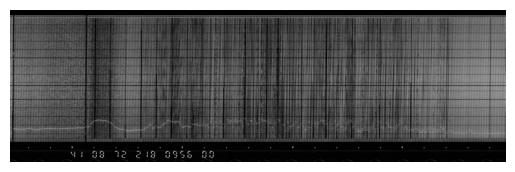

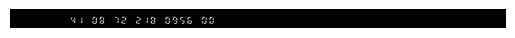

1/1 [==============================] - 1s 914ms/step


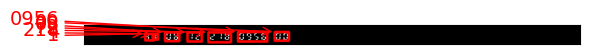

1/1 [==============================] - 1s 519ms/step


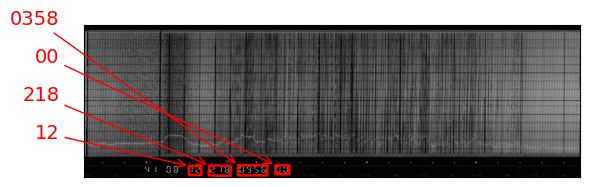

Filtered Image digits count: 15 Original Image digit count: 11


([15, 11], 4)

In [32]:
read_image('L:\\DATA\\ISIS\\ISIS_102000056114\\R014207777\\B1-35-30 ISIS B D-1013\\Image0405.png')

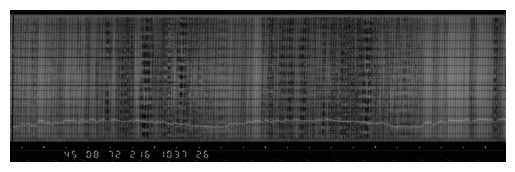

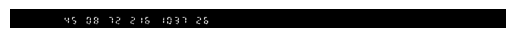

1/1 [==============================] - 1s 678ms/step


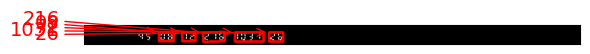

1/1 [==============================] - 1s 572ms/step


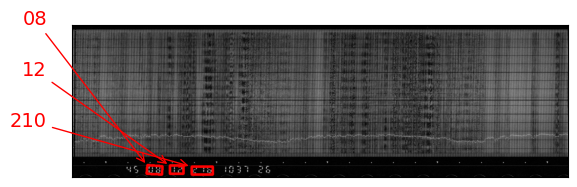

Filtered Image digits count: 13 Original Image digit count: 7


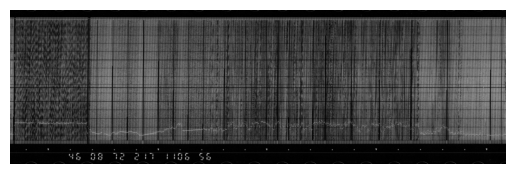

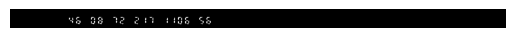

1/1 [==============================] - 1s 552ms/step


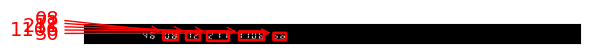

1/1 [==============================] - 0s 263ms/step


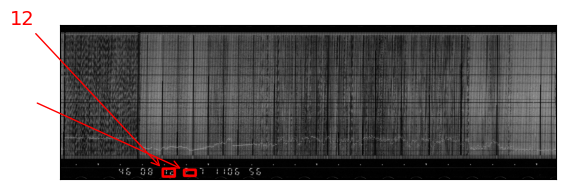

Filtered Image digits count: 13 Original Image digit count: 2


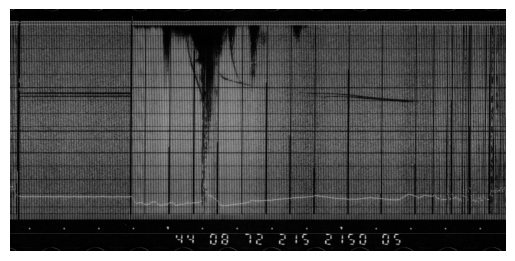

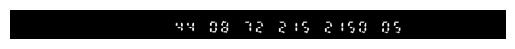

1/1 [==============================] - 1s 674ms/step


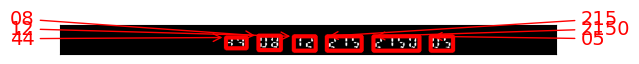

1/1 [==============================] - 0s 467ms/step


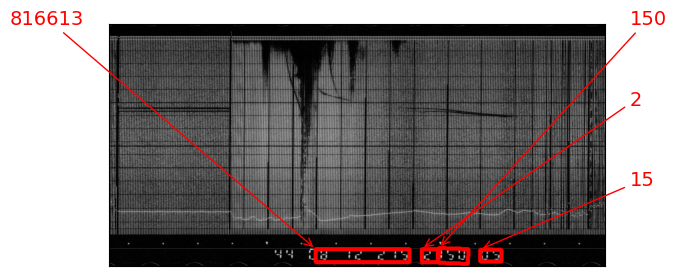

Filtered Image digits count: 15 Original Image digit count: 12


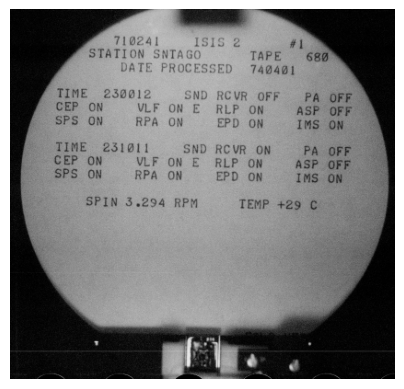

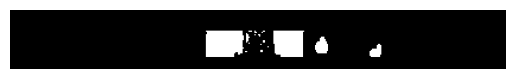

1/1 [==============================] - 1s 552ms/step


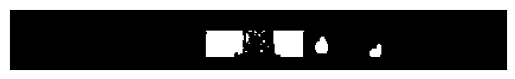

3/3 [==============================] - 8s 2s/step


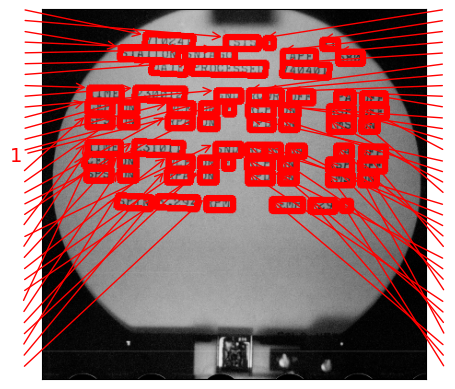

Filtered Image digits count: 0 Original Image digit count: 1


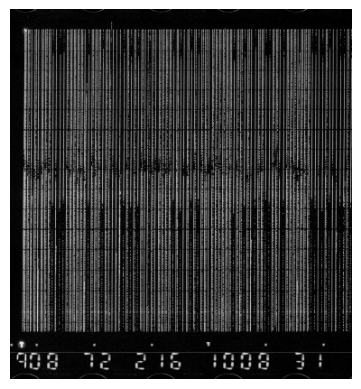

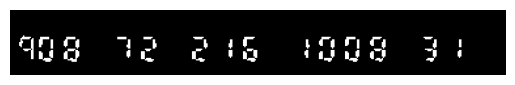

1/1 [==============================] - 1s 552ms/step


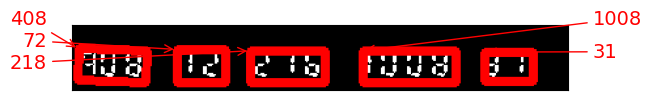

1/1 [==============================] - 1s 540ms/step


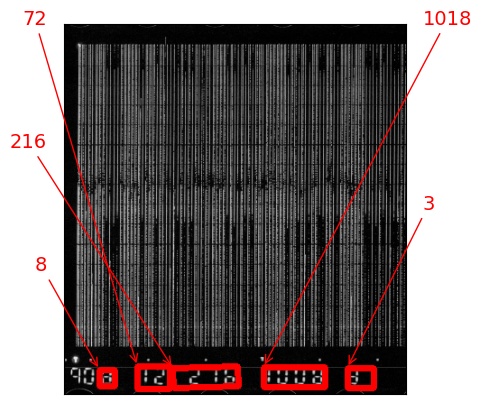

Filtered Image digits count: 14 Original Image digit count: 11


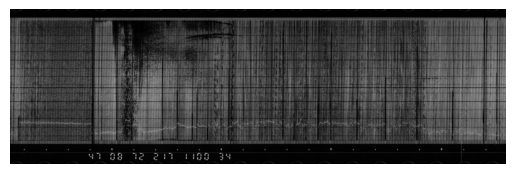

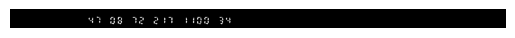

1/1 [==============================] - 1s 584ms/step


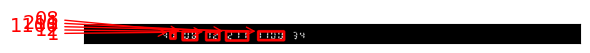

1/1 [==============================] - 0s 276ms/step


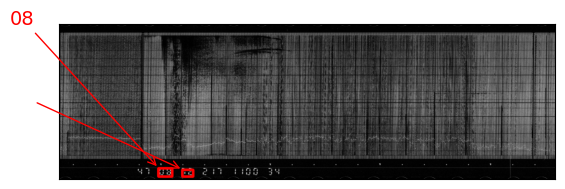

Filtered Image digits count: 12 Original Image digit count: 2


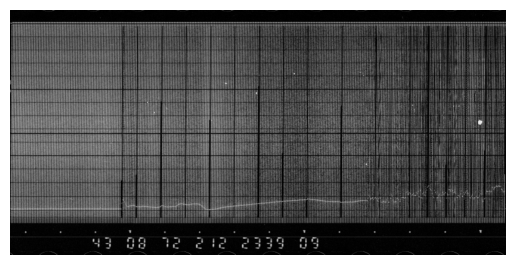

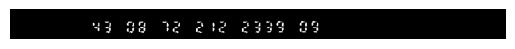

1/1 [==============================] - 1s 672ms/step


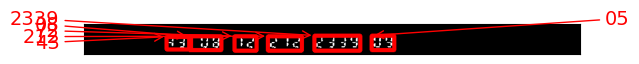

1/1 [==============================] - 1s 631ms/step


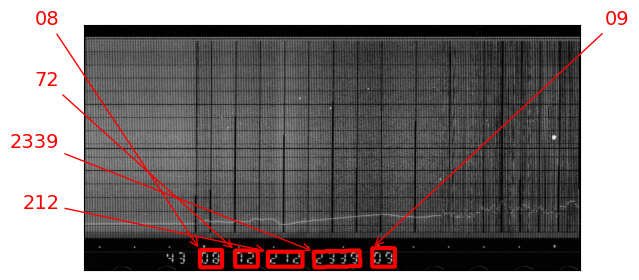

Filtered Image digits count: 15 Original Image digit count: 13


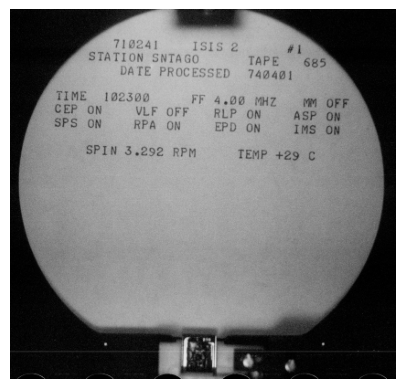

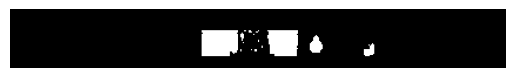

1/1 [==============================] - 0s 426ms/step


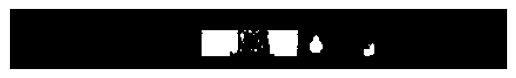

2/2 [==============================] - 5s 1s/step


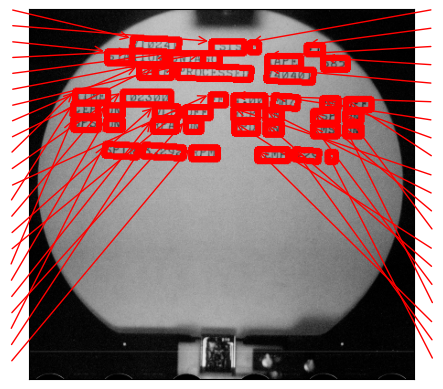

Filtered Image digits count: 0 Original Image digit count: 0


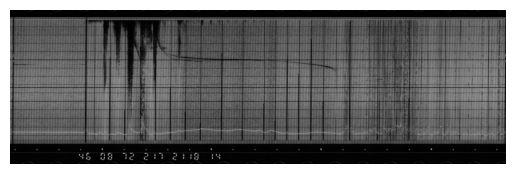

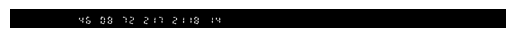

1/1 [==============================] - 0s 469ms/step


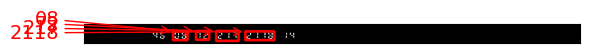

1/1 [==============================] - 0s 272ms/step


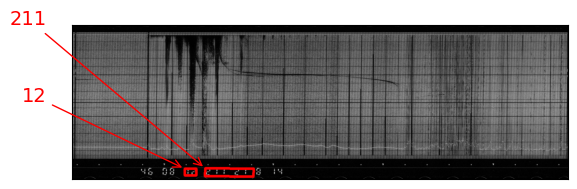

Filtered Image digits count: 11 Original Image digit count: 5


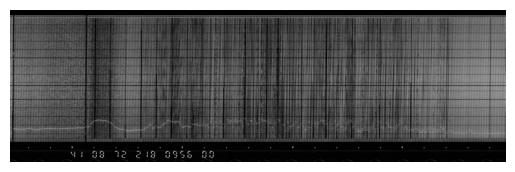

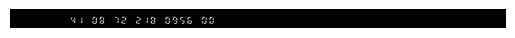

1/1 [==============================] - 1s 747ms/step


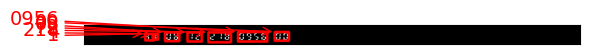

1/1 [==============================] - 1s 539ms/step


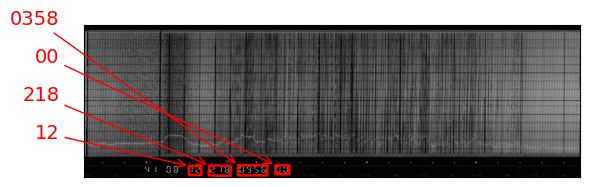

Filtered Image digits count: 15 Original Image digit count: 11


In [30]:
RESULTS_4 = []
for image in sample_set4:
    RESULTS_4.append(read_image(image))